# SLiM-Eval: Complete Small Language Model Evaluation Framework
## Tracking: Latency, Memory, Energy, and Accuracy

This notebook contains:
1. Environment setup and verification
2. Model quantization using llm-compressor
3. **Latency and memory** benchmarking using vLLM
4. **Energy consumption** tracking using CodeCarbon/powermetrics
5. **Accuracy evaluation** using lm-evaluation-harness
6. Results analysis and visualization

## Cell 1: Install Required Packages

In [ ]:
# # # Uncomment and run if packages are not installed
# !pip install accelerate
# !pip install pandas numpy tqdm
# !pip install matplotlib seaborn
# !pip install lm-eval>=0.4.0  # For accuracy evaluation
# !pip install codecarbon 

# !pip install vllm==0.11.0
# !pip install transformers==4.56.2
# # # !pip install llm-compressor
# !pip install llmcompressor
# # !pip install bitsandbytes
# # For energy tracking

In [ ]:
!python --version

In [ ]:
!pip install 'torch==2.8.0' torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

In [ ]:
!pip list

In [ ]:
!pip install 'vllm==0.11.0'

In [ ]:
!pip install 'transformers==4.56.2'

In [ ]:
!pip install llmcompressor

In [ ]:
!pip install 'lm-eval>=0.4.0'  # For accuracy evaluation

In [ ]:
!pip install accelerate
!pip install pandas numpy tqdm
!pip install matplotlib seaborn
!pip install codecarbon # For energy tracking

In [ ]:
!pip install -U ipywidgets

In [14]:
import os

HF_CACHE_DIR = "/mnt/swordfish-pool2/kavin/cache"
CUDA_DEVICE = "6"

os.environ['HF_HOME'] = HF_CACHE_DIR
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_DEVICE

## Cell 2: Import Libraries and Setup

In [ ]:
import gc
import json
import time
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
import psutil
import torch
from tqdm import tqdm
from vllm import LLM, SamplingParams
from huggingface_hub import login

warnings.filterwarnings("ignore")

# Import codecarbon for energy tracking
from codecarbon import EmissionsTracker

# Import lm-eval for accuracy
from lm_eval import evaluator
from lm_eval.models.vllm_causallms import VLLM as VLLM_LM

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB"
    )

from huggingface_hub import login

login(token="<HF_TOKEN>")

PyTorch version: 2.8.0+cu129
CUDA available: True
GPU: NVIDIA RTX A6000
CUDA version: 12.9
GPU Memory: 47.40 GB


## Cell 3: Configuration - Edit This Cell to Customize

In [16]:
# ============================================================================
# EDITABLE MODEL LIST - Add or remove models as needed
# ============================================================================
MODELS = [
    # "microsoft/Phi-3-mini-4k-instruct",  # Phi-3 3.8B
    # "microsoft/Phi-3.5-mini-instruct",  # Phi-3.5 3.8B
    # "google/gemma-2-2b-it",  # Gemma 2 2B
    "meta-llama/Llama-3.2-3B",  # Llama 3.2 3B
    # "Qwen/Qwen2.5-3B-Instruct",  # Qwen2.5 3B
    # "mistralai/Mistral-7B-Instruct-v0.3",  # Mistral 7B
]

# ============================================================================
# BENCHMARK CONFIGURATION
# ============================================================================
# LATENCY & MEMORY BENCHMARKING
NUM_RUNS = 100  # Number of latency benchmark runs
NUM_WARMUP = 10  # Warmup runs to exclude from metrics
MAX_NEW_TOKENS = 32  # Tokens to generate per inference
BATCH_SIZE = 32  # Batch size for vLLM (higher = faster)
PROMPT = "Explain one interesting fact about large language models."

# ACCURACY EVALUATION
ACCURACY_TASKS = [
    "mmlu",  # MMLU (knowledge)
    "gsm8k",  # GSM8K (math reasoning)
    "hellaswag",  # HellaSwag (commonsense reasoning)
    # "humaneval",       # HumanEval (code) - requires unsafe code execution
]
NUM_FEW_SHOT = 5  # Few-shot examples for accuracy tasks
ACCURACY_LIMIT = None  # Set to small number (e.g., 100) for quick testing

# ENERGY TRACKING
ENABLE_ENERGY_TRACKING = True  # Enable/disable energy monitoring
ENERGY_SAMPLE_RUNS = 100  # Number of runs for energy measurement

# ============================================================================
# QUANTIZATION PRECISIONS TO TEST
# ============================================================================
PRECISIONS = ["int8"] # ["fp16", "int8", "int4"]  # Can add "gptq", "awq" later

# ============================================================================
# OUTPUT CONFIGURATION
# ============================================================================
OUTPUT_DIR = Path("slim_eval_results")
OUTPUT_DIR.mkdir(exist_ok=True)
RESULTS_CSV = OUTPUT_DIR / "complete_results.csv"
# QUANTIZED_MODELS_DIR = Path("/mnt/swordfish-pool2/kavin/slimeval/quantized_models")
QUANTIZED_MODELS_DIR = Path("/mnt/swordfish-pool2/kavin/cache")
QUANTIZED_MODELS_DIR.mkdir(exist_ok=True)

print(f"Configuration loaded:")
print(f"  Models: {len(MODELS)}")
print(f"  Precisions: {PRECISIONS}")
print(f"  Latency runs: {NUM_RUNS}")
print(f"  Accuracy tasks: {ACCURACY_TASKS}")
print(f"  Energy tracking: {ENABLE_ENERGY_TRACKING}")
print(f"  Output directory: {OUTPUT_DIR}")

Configuration loaded:
  Models: 1
  Precisions: ['int8']
  Latency runs: 100
  Accuracy tasks: ['mmlu', 'gsm8k', 'hellaswag']
  Energy tracking: True
  Output directory: slim_eval_results


## Cell 4: Utility Functions

In [17]:
def clear_cache():
    """Clear GPU cache and run garbage collection."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()


def get_gpu_memory_mb() -> float:
    """Get current GPU memory usage in MB."""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024**2)
    return 0.0


def get_peak_gpu_memory_mb() -> float:
    """Get peak GPU memory usage in MB."""
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / (1024**2)
    return 0.0


def print_gpu_memory_status():
    """Print current GPU memory status."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(
            f"GPU Memory: {allocated:.2f}GB allocated | {reserved:.2f}GB reserved | {total:.2f}GB total"
        )


print("Utility functions loaded ✓")
print_gpu_memory_status()

Utility functions loaded ✓
GPU Memory: 0.00GB allocated | 0.00GB reserved | 47.40GB total


## Cell 5: Quantization Configuration

In [18]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

from llmcompressor import oneshot
from llmcompressor.modifiers.quantization import GPTQModifier, QuantizationModifier
from llmcompressor.modifiers.smoothquant import SmoothQuantModifier
from llmcompressor.utils import dispatch_for_generation

# Quantization configurations
QUANTIZATION_CONFIGS = {
    "int8": {
        "recipe": [
            SmoothQuantModifier(smoothing_strength=0.8),
            GPTQModifier(targets="Linear", scheme="W8A8", ignore=["lm_head"]),
        ],
        "method": "gptq_smoothquant",
    },
    "int4": {
        "recipe": [
            SmoothQuantModifier(smoothing_strength=0.8),
            GPTQModifier(targets="Linear", scheme="W4A16", ignore=["lm_head"]),
        ],
        "method": "gptq_smoothquant",
    },
    "gptq": {
        "recipe": GPTQModifier(
            targets="Linear",
            scheme="W4A16",
            ignore=["lm_head"],
        ),
        "method": "gptq_only",
    },
}

# Calibration dataset configuration
CALIBRATION_DATASET = "HuggingFaceH4/ultrachat_200k"
CALIBRATION_SPLIT = "train_sft"
NUM_CALIBRATION_SAMPLES = 512
MAX_SEQUENCE_LENGTH = 2048

print("Quantization configurations loaded ✓")
print("  - INT8: W8A8 with SmoothQuant")
print("  - INT4: W4A16 with SmoothQuant + GPTQ")
print("  - GPTQ: W4A16 GPTQ only")

Quantization configurations loaded ✓
  - INT8: W8A8 with SmoothQuant
  - INT4: W4A16 with SmoothQuant + GPTQ
  - GPTQ: W4A16 GPTQ only


In [19]:
# from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# import torch
# from pathlib import Path

# # Quantization configurations using BitsAndBytes
# QUANTIZATION_CONFIGS = {
#     "int8": {
#         "config": BitsAndBytesConfig(
#             load_in_8bit=True,
#             llm_int8_threshold=6.0,
#             llm_int8_has_fp16_weight=False,
#         ),
#         "method": "bitsandbytes_int8",
#         "dtype": torch.float16,
#     },
#     "int4": {
#         "config": BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.float16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type="nf4",  # NormalFloat4 quantization
#         ),
#         "method": "bitsandbytes_nf4",
#         "dtype": torch.float16,
#     },
#     "fp16": {
#         "config": None,  # No quantization, just FP16
#         "method": "fp16_only",
#         "dtype": torch.float16,
#     },
# }

# print("=" * 60)
# print("Quantization configurations loaded ✓")
# print("=" * 60)
# print("Available precisions:")
# print("  - INT8: 8-bit quantization (llm_int8)")
# print("  - INT4: 4-bit NormalFloat quantization (NF4)")
# print("  - FP16: Half precision (no quantization)")
# print("=" * 60)

## Cell 6: Quantization Function (Skip if using pre-quantized models)

In [20]:
def quantize_model(model_name: str, precision: str, output_dir: Path):
    """Quantize a model using llm-compressor with SmoothQuant + GPTQ."""
    print(f"\n{'=' * 60}")
    print(f"Quantizing {model_name} to {precision.upper()}")
    print(f"Output: {output_dir}")
    print(f"{'=' * 60}\n")

    if output_dir.exists() and (output_dir / "config.json").exists():
        print(f"✓ Already quantized, skipping...")
        return

    output_dir.mkdir(parents=True, exist_ok=True)

    try:
        if precision not in QUANTIZATION_CONFIGS:
            print(f"✗ Unsupported precision: {precision}")
            return

        # Load model and tokenizer
        print(f"Loading model and tokenizer...")
        model = AutoModelForCausalLM.from_pretrained(
            model_name, torch_dtype="auto", device_map="auto"
        )
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Load and preprocess calibration dataset
        print(f"Loading calibration dataset: {CALIBRATION_DATASET}")
        ds = load_dataset(
            CALIBRATION_DATASET,
            split=f"{CALIBRATION_SPLIT}[:{NUM_CALIBRATION_SAMPLES}]",
        )
        ds = ds.shuffle(seed=42)

        # Preprocess with chat template (with fallback for models without chat template)
        def preprocess(example):
            try:
                # Try to use chat template if available
                return {
                    "text": tokenizer.apply_chat_template(
                        example["messages"],
                        tokenize=False,
                    )
                }
            except Exception:
                # Fallback: concatenate messages manually
                messages = example["messages"]
                text_parts = []
                for msg in messages:
                    role = msg.get("role", "")
                    content = msg.get("content", "")
                    text_parts.append(f"{role}: {content}")
                return {"text": "\n".join(text_parts)}

        ds = ds.map(preprocess)

        # Tokenize
        def tokenize(sample):
            return tokenizer(
                sample["text"],
                padding=False,
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                add_special_tokens=False,
            )

        ds = ds.map(tokenize, remove_columns=ds.column_names)

        # Get quantization recipe
        quant_config = QUANTIZATION_CONFIGS[precision]
        recipe = quant_config["recipe"]

        print(f"Applying quantization recipe: {quant_config['method']}")

        # Apply quantization
        oneshot(
            model=model,
            dataset=ds,
            recipe=recipe,
            max_seq_length=MAX_SEQUENCE_LENGTH,
            num_calibration_samples=NUM_CALIBRATION_SAMPLES,
        )

        # Verify with sample generation
        print("\n========== SAMPLE GENERATION ==============")
        dispatch_for_generation(model)
        input_ids = tokenizer(
            "Hello my name is", return_tensors="pt"
        ).input_ids.to(model.device)
        output = model.generate(input_ids, max_new_tokens=50)
        print(tokenizer.decode(output[0]))
        print("==========================================\n")

        # Save quantized model
        print(f"Saving to {output_dir}...")
        model.save_pretrained(output_dir, save_compressed=True)
        tokenizer.save_pretrained(output_dir)

        print(f"✓ Quantization complete: {output_dir}")

        # Cleanup
        del model
        clear_cache()

    except Exception as e:
        print(f"✗ Quantization failed: {e}")
        import traceback

        traceback.print_exc()


print("Quantization function loaded ✓")
print("  - Uses SmoothQuant + GPTQ for improved quality")
print("  - Includes generation verification")
print("  - Auto-handles models with/without chat templates")

Quantization function loaded ✓
  - Uses SmoothQuant + GPTQ for improved quality
  - Includes generation verification
  - Auto-handles models with/without chat templates


In [21]:
# def load_quantized_model(model_name, precision="fp16", cache_dir=None):
#     """
#     Load model with specified quantization using BitsAndBytes
    
#     Args:
#         model_name: HuggingFace model identifier
#         precision: One of "int8", "int4", "fp16"
#         cache_dir: Cache directory for model storage
    
#     Returns:
#         model, tokenizer
#     """
#     config = QUANTIZATION_CONFIGS.get(precision)
#     if config is None:
#         raise ValueError(f"Unknown precision: {precision}. Choose from {list(QUANTIZATION_CONFIGS.keys())}")
    
#     print(f"\n{'=' * 60}")
#     print(f"Loading {model_name}")
#     print(f"Precision: {precision.upper()} ({config['method']})")
#     print(f"{'=' * 60}\n")
    
#     try:
#         # Load tokenizer
#         print("Loading tokenizer...")
#         tokenizer = AutoTokenizer.from_pretrained(
#             model_name,
#             cache_dir=cache_dir,
#             trust_remote_code=True
#         )
        
#         # Set padding token if not set
#         if tokenizer.pad_token is None:
#             tokenizer.pad_token = tokenizer.eos_token
        
#         print("✓ Tokenizer loaded")
        
#         # Load model with quantization config
#         print(f"Loading model with {precision} quantization...")
#         model = AutoModelForCausalLM.from_pretrained(
#             model_name,
#             quantization_config=config['config'],
#             device_map="auto",
#             torch_dtype=config['dtype'],
#             cache_dir=cache_dir,
#             trust_remote_code=True
#         )
        
#         print("✓ Model loaded successfully")
        
#         # Optional: Test generation to verify model works
#         print("\n========== SAMPLE GENERATION ==============")
#         test_input = "Hello, my name is"
#         inputs = tokenizer(test_input, return_tensors="pt").to(model.device)
        
#         with torch.no_grad():
#             outputs = model.generate(
#                 **inputs,
#                 max_new_tokens=20,
#                 do_sample=False,
#                 pad_token_id=tokenizer.eos_token_id
#             )
        
#         generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
#         print(f"Input:  '{test_input}'")
#         print(f"Output: '{generated_text}'")
#         print("=" * 43 + "\n")
        
#         return model, tokenizer
        
#     except Exception as e:
#         print(f"✗ Model loading failed: {e}")
#         import traceback
#         traceback.print_exc()
#         return None, None


# def quantize_model(model_name: str, precision: str, output_dir: Path):
#     """
#     Load and optionally save a quantized model.
    
#     Note: With BitsAndBytes, quantization happens on-the-fly during loading.
#     This function loads the model and can save it for later use.
#     """
#     print(f"\n{'=' * 60}")
#     print(f"Processing {model_name} with {precision.upper()}")
#     print(f"Output: {output_dir}")
#     print(f"{'=' * 60}\n")
    
#     # Check if already processed
#     if output_dir.exists() and (output_dir / "config.json").exists():
#         print(f"✓ Already processed, skipping...")
#         return
    
#     output_dir.mkdir(parents=True, exist_ok=True)
    
#     # Load the quantized model
#     model, tokenizer = load_quantized_model(model_name, precision, cache_dir=HF_CACHE_DIR)
    
#     if model is None:
#         print("✗ Failed to load model")
#         return
    
#     # Save the model and tokenizer
#     try:
#         print(f"\nSaving to {output_dir}...")
#         model.save_pretrained(output_dir)
#         tokenizer.save_pretrained(output_dir)
#         print(f"✓ Saved successfully: {output_dir}\n")
        
#     except Exception as e:
#         print(f"✗ Save failed: {e}")
#         import traceback
#         traceback.print_exc()
    
#     finally:
#         # Cleanup to free memory
#         del model
#         del tokenizer
#         torch.cuda.empty_cache()
#         print("✓ Memory cleared")


# print("=" * 60)
# print("Quantization functions loaded ✓")
# print("=" * 60)
# print("Functions available:")
# print("  - load_quantized_model(model_name, precision, cache_dir)")
# print("  - quantize_model(model_name, precision, output_dir)")
# print("=" * 60)

## Cell 7: vLLM Model Setup Function

In [22]:
def setup_vllm_model(
    model_name: str, precision: str, use_quantized_dir: bool = True
) -> Optional[LLM]:
    """Setup vLLM model with specified precision."""
    clear_cache()

    try:
        print(f"\n{'=' * 60}")
        print(f"Loading {model_name} in {precision.upper()} precision...")
        print(f"{'=' * 60}")

        if precision == "fp16":
            model_path = model_name
            dtype = "float16"
            quantization = None
        else:
            model_short_name = model_name.split("/")[-1]
            quantized_path = QUANTIZED_MODELS_DIR / f"{model_short_name}_{precision}"

            if use_quantized_dir and quantized_path.exists():
                # Pre-quantized model exists
                model_path = str(quantized_path)
                dtype = "auto"
                quantization = None  # Model is already quantized, vLLM auto-detects
                print(f"Using pre-quantized model from: {quantized_path}")
                print(f"  Method: {QUANTIZATION_CONFIGS[precision]['method']}")
            elif use_quantized_dir:
                # Pre-quantized model doesn't exist, create it
                print(f"Pre-quantized model not found at: {quantized_path}")
                print(f"Running quantization with llm-compressor...")
                quantize_model(model_name, precision, quantized_path)
                
                # Now use the quantized model
                if quantized_path.exists():
                    model_path = str(quantized_path)
                    dtype = "auto"
                    quantization = None
                    print(f"Using newly quantized model from: {quantized_path}")
                else:
                    # Quantization failed, fall back to on-the-fly
                    print(f"⚠️  Quantization failed, falling back to on-the-fly quantization")
                    model_path = model_name
                    dtype = "auto"
                    if precision == "int8":
                        quantization = "int8"
                    elif precision == "int4":
                        quantization = "int4"
                    elif precision == "gptq":
                        quantization = "gptq"
                    elif precision == "awq":
                        quantization = "awq"
                    else:
                        raise ValueError(f"Unknown precision: {precision}")
            else:
                # On-the-fly quantization (use_quantized_dir=False)
                model_path = model_name
                dtype = "auto"
                print(f"⚠️  Using base model with on-the-fly quantization: {precision}")
                print(f"   For best quality, pre-quantize with llm-compressor first")
                
                # Set vLLM quantization method
                if precision == "int8":
                    quantization = "int8"
                elif precision == "int4":
                    quantization = "int4"
                elif precision == "gptq":
                    quantization = "gptq"
                elif precision == "awq":
                    quantization = "awq"
                else:
                    raise ValueError(f"Unknown precision: {precision}")

        llm = LLM(
            model=model_path,
            dtype=dtype,
            quantization=quantization,
            gpu_memory_utilization=0.7,
            max_model_len=2048,
            tensor_parallel_size=1,
            trust_remote_code=True,
        )

        print(f"✓ Model loaded successfully")
        print_gpu_memory_status()
        return llm

    except Exception as e:
        print(f"✗ Failed to load {model_name} in {precision}: {e}")
        import traceback

        traceback.print_exc()
        return None


print("Model setup function loaded ✓")
print("  - Auto-detects pre-quantized models from llm-compressor")
print("  - Automatically quantizes models if not found")
print("  - Falls back to vLLM on-the-fly quantization if needed")

Model setup function loaded ✓
  - Auto-detects pre-quantized models from llm-compressor
  - Automatically quantizes models if not found
  - Falls back to vLLM on-the-fly quantization if needed


## Cell 8: Latency & Memory Benchmarking Function

In [23]:
def benchmark_latency_memory(
    llm: LLM,
    model_name: str,
    precision: str,
    num_runs: int = NUM_RUNS,
    num_warmup: int = NUM_WARMUP,
    batch_size: int = BATCH_SIZE,
) -> Dict:
    """Benchmark vLLM model for latency and memory."""
    sampling_params = SamplingParams(
        temperature=0.0,
        max_tokens=MAX_NEW_TOKENS,
        top_p=1.0,
    )

    latencies = []
    peak_memories = []
    avg_memories = []
    tokens_generated = []

    total_iterations = (num_runs + num_warmup + batch_size - 1) // batch_size

    print(f"\n{'=' * 60}")
    print(f"LATENCY & MEMORY BENCHMARK")
    print(f"{'=' * 60}")
    print(f"Warmup: {num_warmup} | Benchmark: {num_runs} | Batch: {batch_size}")

    iteration_count = 0
    pbar = tqdm(total=num_runs + num_warmup, desc="Latency/Memory")

    for batch_idx in range(total_iterations):
        current_batch_size = min(batch_size, num_runs + num_warmup - iteration_count)
        prompts = [PROMPT] * current_batch_size

        clear_cache()
        torch.cuda.reset_peak_memory_stats()

        start_time = time.time()
        outputs = llm.generate(prompts, sampling_params)
        torch.cuda.synchronize()
        end_time = time.time()

        batch_latency = end_time - start_time
        peak_mem = get_peak_gpu_memory_mb()
        avg_mem = get_gpu_memory_mb()
        per_request_latency = batch_latency / current_batch_size
        batch_tokens = sum(len(output.outputs[0].token_ids) for output in outputs)

        for i in range(current_batch_size):
            if iteration_count >= num_warmup:
                latencies.append(per_request_latency)
                peak_memories.append(peak_mem)
                avg_memories.append(avg_mem)
                tokens_generated.append(batch_tokens / current_batch_size)

            iteration_count += 1
            pbar.update(1)

            if iteration_count >= num_runs + num_warmup:
                break

        if iteration_count >= num_runs + num_warmup:
            break

    pbar.close()

    lat = np.array(latencies)
    pm = np.array(peak_memories)
    am = np.array(avg_memories)
    tg = np.array(tokens_generated)

    results = {
        "mean_latency_s": lat.mean(),
        "median_latency_s": np.median(lat),
        "p95_latency_s": np.percentile(lat, 95),
        "p99_latency_s": np.percentile(lat, 99),
        "std_latency_s": lat.std(),
        "mean_peak_mem_mb": pm.mean(),
        "mean_avg_mem_mb": am.mean(),
        "tokens_per_second": tg.mean() / lat.mean(),
    }

    print(
        f"✓ Latency: {results['mean_latency_s']:.4f}s | Memory: {results['mean_peak_mem_mb']:.2f}MB"
    )
    return results


print("Latency/Memory benchmark function loaded ✓")

Latency/Memory benchmark function loaded ✓


## Cell 9: Energy Tracking Function

In [24]:
def benchmark_energy(
    llm: LLM,
    model_name: str,
    precision: str,
    num_samples: int = ENERGY_SAMPLE_RUNS
) -> Dict:
    """Measure energy consumption using CodeCarbon."""
    
    print(f"\n{'='*60}")
    print(f"ENERGY CONSUMPTION BENCHMARK")
    print(f"{'='*60}")
    print(f"Running {num_samples} inference samples with energy tracking...")
    
    sampling_params = SamplingParams(
        temperature=0.0,
        max_tokens=MAX_NEW_TOKENS,
        top_p=1.0,
    )
    
    # Test prompts
    test_prompts = [
        "Explain quantum computing in simple terms.",
        "Write a Python function to calculate fibonacci numbers.",
        "What are the main causes of climate change?",
        "Solve: If x + 5 = 12, what is x?",
        "Describe the process of photosynthesis.",
    ]
    
    try:
        # Create energy logs directory
        energy_logs_dir = OUTPUT_DIR / "energy_logs"
        energy_logs_dir.mkdir(parents=True, exist_ok=True)
        
        # Initialize energy tracker
        tracker = EmissionsTracker(
            project_name=f"slim_eval_{model_name.split('/')[-1]}_{precision}",
            output_dir=str(energy_logs_dir),
            log_level="warning",
            save_to_file=True,
        )
        
        # Start tracking
        tracker.start()
        start_time = time.time()
        
        # Run inference samples
        for i in tqdm(range(num_samples), desc="Energy tracking"):
            prompt = test_prompts[i % len(test_prompts)]
            prompts_batch = [prompt]
            outputs = llm.generate(prompts_batch, sampling_params)
        
        # Stop tracking
        end_time = time.time()
        emissions = tracker.stop()
        
        duration = end_time - start_time
        
        # Handle case where emissions might be None
        if emissions is None or emissions == 0:
            print("⚠️  CodeCarbon returned no emissions data")
            # Provide fallback with timing only
            results = {
                "energy_kwh": 0,
                "energy_joules": 0,
                "duration_seconds": duration,
                "avg_power_watts": 0,
                "num_samples": num_samples,
                "energy_per_query_j": 0,
                "note": "Energy tracking unavailable - timing only"
            }
        else:
            results = {
                "energy_kwh": emissions,  # kWh
                "energy_joules": emissions * 3600000,  # Convert kWh to Joules
                "duration_seconds": duration,
                "avg_power_watts": (emissions * 3600000 / duration) if duration > 0 else 0,
                "num_samples": num_samples,
                "energy_per_query_j": (emissions * 3600000 / num_samples) if num_samples > 0 else 0,
            }
        
        print(f"✓ Energy: {results['energy_kwh']*1000:.4f} Wh | Avg Power: {results['avg_power_watts']:.2f}W")
        return results
        
    except Exception as e:
        print(f"⚠️  Energy tracking failed: {e}")
        # Return fallback results with timing only
        end_time = time.time()
        duration = end_time - start_time if 'start_time' in locals() else 0
        
        return {
            "energy_kwh": 0,
            "energy_joules": 0,
            "duration_seconds": duration,
            "avg_power_watts": 0,
            "num_samples": num_samples,
            "energy_per_query_j": 0,
            "error": str(e),
            "note": "Energy tracking failed - timing only"
        }

print("Energy benchmark function loaded ✓")

Energy benchmark function loaded ✓


## Cell 10: Accuracy Evaluation Function

In [25]:
def benchmark_accuracy(
    model_name: str,
    precision: str,
    tasks: List[str] = ACCURACY_TASKS,
    num_fewshot: int = NUM_FEW_SHOT,
    limit: Optional[int] = ACCURACY_LIMIT,
) -> Dict:
    """Evaluate model accuracy using lm-evaluation-harness with vLLM backend."""

    print(f"\n{'=' * 60}")
    print(f"ACCURACY EVALUATION")
    print(f"{'=' * 60}")
    print(f"Tasks: {', '.join(tasks)}")
    print(f"Few-shot: {num_fewshot}")
    if limit:
        print(f"Limit: {limit} examples per task")

    try:
        # Determine model path and arguments
        if precision == "fp16":
            model_path = model_name
            model_args = f"pretrained={model_path},dtype=float16,gpu_memory_utilization=0.7,max_model_len=2048,tensor_parallel_size=1"
        else:
            model_short_name = model_name.split("/")[-1]
            quantized_path = QUANTIZED_MODELS_DIR / f"{model_short_name}_{precision}"
            
            # Use quantized model if it exists, otherwise use base model with quantization flag
            if quantized_path.exists():
                model_path = str(quantized_path)
                print(f"Using pre-quantized model: {model_path}")
            else:
                model_path = model_name
                print(f"Using base model with on-the-fly quantization: {precision}")
            
            # Build model arguments for vLLM
            model_args = f"pretrained={model_path},dtype=auto,gpu_memory_utilization=0.7,max_model_len=2048,tensor_parallel_size=1"
            
            # Add quantization parameter if using base model
            if not quantized_path.exists():
                if precision in ["int8", "int4", "gptq", "awq"]:
                    model_args += f",quantization={precision}"

        # Run evaluation using lm-eval CLI-style interface
        results = evaluator.simple_evaluate(
            model="vllm",
            model_args=model_args,
            tasks=tasks,
            num_fewshot=num_fewshot,
            batch_size="auto",
            limit=limit,
            log_samples=False,
        )

        # Extract metrics
        accuracy_results = {}
        for task_name, task_results in results["results"].items():
            # Find accuracy metric (different tasks use different metric names)
            if "acc" in task_results:
                accuracy_results[f"{task_name}_accuracy"] = task_results["acc"]
            elif "acc_norm" in task_results:
                accuracy_results[f"{task_name}_accuracy"] = task_results["acc_norm"]
            elif "exact_match" in task_results:
                accuracy_results[f"{task_name}_accuracy"] = task_results["exact_match"]
            elif "pass@1" in task_results:
                accuracy_results[f"{task_name}_accuracy"] = task_results["pass@1"]
            else:
                # Take the first metric that looks like accuracy
                for key, value in task_results.items():
                    if isinstance(value, (int, float)) and 0 <= value <= 1:
                        accuracy_results[f"{task_name}_accuracy"] = value
                        break

        print(f"✓ Accuracy results:")
        for task, acc in accuracy_results.items():
            print(f"  {task}: {acc:.4f} ({acc * 100:.2f}%)")

        return accuracy_results

    except Exception as e:
        print(f"⚠️  Accuracy evaluation failed: {e}")
        import traceback

        traceback.print_exc()
        return {f"{task}_accuracy": 0 for task in tasks}


print("Accuracy benchmark function loaded ✓")
print("  - Uses lm-eval with vLLM backend")
print("  - Supports both pre-quantized and on-the-fly quantization")

Accuracy benchmark function loaded ✓
  - Uses lm-eval with vLLM backend
  - Supports both pre-quantized and on-the-fly quantization


## Cell 11: Main Benchmarking Loop

In [26]:
def run_complete_benchmark(model_name: str, precision: str) -> Dict:
    """Run complete benchmark: latency, memory, energy, and accuracy."""

    print(f"\n{'#' * 70}")
    print(f"COMPLETE BENCHMARK: {model_name} ({precision.upper()})")
    print(f"{'#' * 70}")

    results = {
        "model": model_name,
        "precision": precision,
        "timestamp": datetime.now().isoformat(),
    }

    # Setup model
    llm = setup_vllm_model(model_name, precision)
    if llm is None:
        print(f"✗ Model setup failed, skipping...")
        return None

    try:
        # 1. Latency & Memory
        latency_memory_results = benchmark_latency_memory(llm, model_name, precision)
        results.update(latency_memory_results)

        # 2. Energy (if enabled)
        if ENABLE_ENERGY_TRACKING:
            energy_results = benchmark_energy(llm, model_name, precision)
            results.update(energy_results)

        # Clean up vLLM model before accuracy eval
        del llm
        clear_cache()
        time.sleep(2)

        # # 3. Accuracy
        # accuracy_results = benchmark_accuracy(model_name, precision)
        # results.update(accuracy_results)

        return results

    except Exception as e:
        print(f"✗ Benchmark failed: {e}")
        import traceback

        traceback.print_exc()
        return None
    finally:
        clear_cache()


print("Complete benchmark function loaded ✓")

Complete benchmark function loaded ✓


## Cell 12: Initialize Results CSV

In [27]:
# Define all possible columns
base_columns = [
    "model",
    "precision",
    "timestamp",
    "mean_latency_s",
    "median_latency_s",
    "p95_latency_s",
    "p99_latency_s",
    "std_latency_s",
    "mean_peak_mem_mb",
    "mean_avg_mem_mb",
    "tokens_per_second",
]

energy_columns = [
    "energy_kwh",
    "energy_joules",
    "duration_seconds",
    "avg_power_watts",
    "energy_per_query_j",
]

accuracy_columns = [f"{task}_accuracy" for task in ACCURACY_TASKS]

all_columns = base_columns + energy_columns + accuracy_columns

if not RESULTS_CSV.exists():
    pd.DataFrame(columns=all_columns).to_csv(RESULTS_CSV, index=False)
    print(f"✓ Created results CSV: {RESULTS_CSV}")
else:
    print(f"✓ Results CSV exists: {RESULTS_CSV}")

✓ Results CSV exists: slim_eval_results/complete_results.csv


## Cell 13: Run All Benchmarks
**This cell runs everything. Will take several hours!**

In [28]:
print(f"\n{'#' * 70}")
print("SLiM-Eval: COMPLETE BENCHMARK SUITE")
print(f"{'#' * 70}\n")
print(f"Models: {len(MODELS)}")
print(f"Precisions: {PRECISIONS}")
print(f"Total configs: {len(MODELS) * len(PRECISIONS)}")
print(f"Metrics: Latency, Memory, Energy, Accuracy")
print(f"Output: {RESULTS_CSV}")
print(f"\nEstimated time: ~{len(MODELS) * len(PRECISIONS) * 30} minutes")

all_results = []

for model_name in MODELS:
    for precision in PRECISIONS:
        config_id = f"{model_name.split('/')[-1]}_{precision}"

        # Run complete benchmark
        results = run_complete_benchmark(model_name, precision)

        if results:
            all_results.append(results)

            # Save incrementally
            pd.DataFrame([results]).to_csv(
                RESULTS_CSV, mode="a", header=False, index=False
            )
            print(f"\n✓ Results saved for {config_id}")

        # Cleanup between configs
        clear_cache()
        time.sleep(5)

print(f"\n{'#' * 70}")
print("ALL BENCHMARKS COMPLETE!")
print(f"{'#' * 70}")


######################################################################
SLiM-Eval: COMPLETE BENCHMARK SUITE
######################################################################

Models: 1
Precisions: ['int8']
Total configs: 1
Metrics: Latency, Memory, Energy, Accuracy
Output: slim_eval_results/complete_results.csv

Estimated time: ~30 minutes

######################################################################
COMPLETE BENCHMARK: meta-llama/Llama-3.2-3B (INT8)
######################################################################

Loading meta-llama/Llama-3.2-3B in INT8 precision...
Pre-quantized model not found at: /mnt/swordfish-pool2/kavin/cache/Llama-3.2-3B_int8
Running quantization with llm-compressor...

Quantizing meta-llama/Llama-3.2-3B to INT8
Output: /mnt/swordfish-pool2/kavin/cache/Llama-3.2-3B_int8

Loading model and tokenizer...


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Loading calibration dataset: HuggingFaceH4/ultrachat_200k


README.md: 0.00B [00:00, ?B/s]

data/train_sft-00000-of-00003-a3ecf92756(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

data/train_sft-00001-of-00003-0a1804bcb6(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

data/train_sft-00002-of-00003-ee46ed25cf(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

data/test_sft-00000-of-00001-f7dfac4afe5(…):   0%|          | 0.00/81.2M [00:00<?, ?B/s]

data/train_gen-00000-of-00003-a6c9fb894b(…):   0%|          | 0.00/244M [00:00<?, ?B/s]

data/train_gen-00001-of-00003-d6a0402e41(…):   0%|          | 0.00/243M [00:00<?, ?B/s]

data/train_gen-00002-of-00003-c0db75b92a(…):   0%|          | 0.00/243M [00:00<?, ?B/s]

data/test_gen-00000-of-00001-3d4cd830914(…):   0%|          | 0.00/80.4M [00:00<?, ?B/s]

Generating train_sft split:   0%|          | 0/207865 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/23110 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/256032 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/28304 [00:00<?, ? examples/s]

Map:   0%|          | 0/512 [00:00<?, ? examples/s]

Map:   0%|          | 0/512 [00:00<?, ? examples/s]

Applying quantization recipe: gptq_smoothquant
2025-11-29T00:09:00.299504-0500 | reset | INFO - Compression lifecycle reset
2025-11-29T00:09:00.305635-0500 | _create_default_logger | INFO - Logging all LLM Compressor modifier-level logs to sparse_logs/29-11-2025_00.09.00.log
2025-11-29T00:09:00.307830-0500 | from_modifiers | INFO - Creating recipe from modifiers
2025-11-29T00:09:00.308843-0500 | _infer_mappings_from_model | INFO - No SmoothQuantModifier.mappings provided, inferring from model...
2025-11-29T00:09:00.873274-0500 | initialize | INFO - Compression lifecycle initialized for 2 modifiers
2025-11-29T00:09:00.874115-0500 | IndependentPipeline | INFO - Inferred `SequentialPipeline` for `SmoothQuantModifier`


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2025-11-29T00:09:08.935719-0500 | _apply_smoothing | INFO - Smoothing with model.layers.0.input_layernorm


2025-11-29T00:09:09.126180-0500 | _apply_smoothing | INFO - Smoothing with model.layers.0.post_attention_layernorm


(2/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 210.89it/s]

2025-11-29T00:09:14.857897-0500 | _apply_smoothing | INFO - Smoothing with model.layers.1.input_layernorm
2025-11-29T00:09:14.859454-0500 | _apply_smoothing | INFO - Smoothing with model.layers.1.post_attention_layernorm



(3/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 213.02it/s]

2025-11-29T00:09:20.332776-0500 | _apply_smoothing | INFO - Smoothing with model.layers.2.input_layernorm
2025-11-29T00:09:20.334197-0500 | _apply_smoothing | INFO - Smoothing with model.layers.2.post_attention_layernorm



(4/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 213.42it/s]

2025-11-29T00:09:25.472747-0500 | _apply_smoothing | INFO - Smoothing with model.layers.3.input_layernorm
2025-11-29T00:09:25.474209-0500 | _apply_smoothing | INFO - Smoothing with model.layers.3.post_attention_layernorm



(5/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 211.89it/s]

2025-11-29T00:09:30.682423-0500 | _apply_smoothing | INFO - Smoothing with model.layers.4.input_layernorm
2025-11-29T00:09:30.684159-0500 | _apply_smoothing | INFO - Smoothing with model.layers.4.post_attention_layernorm



(6/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 212.25it/s]

2025-11-29T00:09:35.932587-0500 | _apply_smoothing | INFO - Smoothing with model.layers.5.input_layernorm
2025-11-29T00:09:35.933986-0500 | _apply_smoothing | INFO - Smoothing with model.layers.5.post_attention_layernorm



(7/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 209.18it/s]

2025-11-29T00:09:41.081565-0500 | _apply_smoothing | INFO - Smoothing with model.layers.6.input_layernorm
2025-11-29T00:09:41.083165-0500 | _apply_smoothing | INFO - Smoothing with model.layers.6.post_attention_layernorm



(8/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 208.60it/s]

2025-11-29T00:09:46.488369-0500 | _apply_smoothing | INFO - Smoothing with model.layers.7.input_layernorm
2025-11-29T00:09:46.489774-0500 | _apply_smoothing | INFO - Smoothing with model.layers.7.post_attention_layernorm



(9/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 209.19it/s]

2025-11-29T00:09:51.854489-0500 | _apply_smoothing | INFO - Smoothing with model.layers.8.input_layernorm
2025-11-29T00:09:51.855899-0500 | _apply_smoothing | INFO - Smoothing with model.layers.8.post_attention_layernorm



(10/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 212.04it/s]

2025-11-29T00:09:57.139604-0500 | _apply_smoothing | INFO - Smoothing with model.layers.9.input_layernorm
2025-11-29T00:09:57.141157-0500 | _apply_smoothing | INFO - Smoothing with model.layers.9.post_attention_layernorm



(11/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 211.12it/s]

2025-11-29T00:10:02.408316-0500 | _apply_smoothing | INFO - Smoothing with model.layers.10.input_layernorm
2025-11-29T00:10:02.409714-0500 | _apply_smoothing | INFO - Smoothing with model.layers.10.post_attention_layernorm



(12/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 211.64it/s]

2025-11-29T00:10:07.694501-0500 | _apply_smoothing | INFO - Smoothing with model.layers.11.input_layernorm
2025-11-29T00:10:07.696085-0500 | _apply_smoothing | INFO - Smoothing with model.layers.11.post_attention_layernorm



(13/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 210.20it/s]

2025-11-29T00:10:12.917524-0500 | _apply_smoothing | INFO - Smoothing with model.layers.12.input_layernorm
2025-11-29T00:10:12.918878-0500 | _apply_smoothing | INFO - Smoothing with model.layers.12.post_attention_layernorm



(14/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 208.91it/s]

2025-11-29T00:10:18.185599-0500 | _apply_smoothing | INFO - Smoothing with model.layers.13.input_layernorm
2025-11-29T00:10:18.186992-0500 | _apply_smoothing | INFO - Smoothing with model.layers.13.post_attention_layernorm



(15/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 209.88it/s]

2025-11-29T00:10:23.345584-0500 | _apply_smoothing | INFO - Smoothing with model.layers.14.input_layernorm
2025-11-29T00:10:23.347157-0500 | _apply_smoothing | INFO - Smoothing with model.layers.14.post_attention_layernorm



(16/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 209.02it/s]

2025-11-29T00:10:28.653768-0500 | _apply_smoothing | INFO - Smoothing with model.layers.15.input_layernorm
2025-11-29T00:10:28.655492-0500 | _apply_smoothing | INFO - Smoothing with model.layers.15.post_attention_layernorm



(17/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 207.23it/s]

2025-11-29T00:10:34.075893-0500 | _apply_smoothing | INFO - Smoothing with model.layers.16.input_layernorm
2025-11-29T00:10:34.077585-0500 | _apply_smoothing | INFO - Smoothing with model.layers.16.post_attention_layernorm



(18/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 208.80it/s]

2025-11-29T00:10:39.366614-0500 | _apply_smoothing | INFO - Smoothing with model.layers.17.input_layernorm
2025-11-29T00:10:39.368111-0500 | _apply_smoothing | INFO - Smoothing with model.layers.17.post_attention_layernorm



(19/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 205.89it/s]

2025-11-29T00:10:44.777253-0500 | _apply_smoothing | INFO - Smoothing with model.layers.18.input_layernorm
2025-11-29T00:10:44.778652-0500 | _apply_smoothing | INFO - Smoothing with model.layers.18.post_attention_layernorm



(20/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 205.34it/s]

2025-11-29T00:10:50.188046-0500 | _apply_smoothing | INFO - Smoothing with model.layers.19.input_layernorm
2025-11-29T00:10:50.189437-0500 | _apply_smoothing | INFO - Smoothing with model.layers.19.post_attention_layernorm



(21/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 207.89it/s]

2025-11-29T00:10:55.630977-0500 | _apply_smoothing | INFO - Smoothing with model.layers.20.input_layernorm
2025-11-29T00:10:55.632425-0500 | _apply_smoothing | INFO - Smoothing with model.layers.20.post_attention_layernorm



(22/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 208.93it/s]

2025-11-29T00:11:00.865707-0500 | _apply_smoothing | INFO - Smoothing with model.layers.21.input_layernorm
2025-11-29T00:11:00.867161-0500 | _apply_smoothing | INFO - Smoothing with model.layers.21.post_attention_layernorm



(23/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 208.32it/s]

2025-11-29T00:11:06.104261-0500 | _apply_smoothing | INFO - Smoothing with model.layers.22.input_layernorm
2025-11-29T00:11:06.105955-0500 | _apply_smoothing | INFO - Smoothing with model.layers.22.post_attention_layernorm



(24/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 208.46it/s]

2025-11-29T00:11:11.403853-0500 | _apply_smoothing | INFO - Smoothing with model.layers.23.input_layernorm
2025-11-29T00:11:11.405463-0500 | _apply_smoothing | INFO - Smoothing with model.layers.23.post_attention_layernorm



(25/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 208.29it/s]

2025-11-29T00:11:16.729701-0500 | _apply_smoothing | INFO - Smoothing with model.layers.24.input_layernorm
2025-11-29T00:11:16.731193-0500 | _apply_smoothing | INFO - Smoothing with model.layers.24.post_attention_layernorm



(26/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 205.68it/s]

2025-11-29T00:11:22.130142-0500 | _apply_smoothing | INFO - Smoothing with model.layers.25.input_layernorm
2025-11-29T00:11:22.131646-0500 | _apply_smoothing | INFO - Smoothing with model.layers.25.post_attention_layernorm



(27/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 205.48it/s]

2025-11-29T00:11:27.592282-0500 | _apply_smoothing | INFO - Smoothing with model.layers.26.input_layernorm
2025-11-29T00:11:27.593729-0500 | _apply_smoothing | INFO - Smoothing with model.layers.26.post_attention_layernorm



(28/29): Calibrating: 100%|██████████| 512/512 [00:02<00:00, 206.99it/s]

2025-11-29T00:11:32.997634-0500 | _apply_smoothing | INFO - Smoothing with model.layers.27.input_layernorm
2025-11-29T00:11:32.999100-0500 | _apply_smoothing | INFO - Smoothing with model.layers.27.post_attention_layernorm



(29/29): Propagating: 100%|██████████| 512/512 [00:04<00:00, 114.49it/s]


2025-11-29T00:11:45.261978-0500 | IndependentPipeline | INFO - Inferred `SequentialPipeline` for `GPTQModifier`


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2025-11-29T00:11:57.298266-0500 | compress_modules | INFO - Quantizing model.layers.0.self_attn.q_proj using 512 samples


2025-11-29T00:11:59.205550-0500 | compress | METRIC - time 1.91s
2025-11-29T00:11:59.206501-0500 | compress | METRIC - error 61.69
2025-11-29T00:11:59.207589-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:11:59.207932-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:11:59.208215-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:11:59.208509-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:11:59.208786-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:11:59.209057-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:11:59.209380-0500 | compress | METRIC - GPU 6 | usage: 6.09% | total memory: 51 GB
2025-11-29T00:11:59.209694-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:11:59.210047-0500 | compress | METRIC - Compressed module size: 18.883584 MB

(2/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.79it/s]

2025-11-29T00:12:20.897464-0500 | compress_modules | INFO - Quantizing model.layers.1.self_attn.q_proj using 512 samples


2025-11-29T00:12:22.009969-0500 | compress | METRIC - time 1.11s
2025-11-29T00:12:22.011101-0500 | compress | METRIC - error 49.21
2025-11-29T00:12:22.011761-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:12:22.012074-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:12:22.012406-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:12:22.012710-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:12:22.013031-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:12:22.013325-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:12:22.013623-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:12:22.013918-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:12:22.014236-0500 | compress | METRIC - Compressed module size: 18.883584 MB

(3/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.05it/s]

2025-11-29T00:12:43.169258-0500 | compress_modules | INFO - Quantizing model.layers.2.self_attn.q_proj using 512 samples


2025-11-29T00:12:44.270029-0500 | compress | METRIC - time 1.10s
2025-11-29T00:12:44.271433-0500 | compress | METRIC - error 142.01
2025-11-29T00:12:44.272380-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:12:44.272781-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:12:44.273136-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:12:44.273445-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:12:44.273770-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:12:44.274078-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:12:44.274692-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:12:44.275004-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:12:44.275561-0500 | compress | METRIC - Compressed module size: 18.883584 M

(4/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 49.38it/s]

2025-11-29T00:13:06.974584-0500 | compress_modules | INFO - Quantizing model.layers.3.self_attn.q_proj using 512 samples


2025-11-29T00:13:08.064986-0500 | compress | METRIC - time 1.09s
2025-11-29T00:13:08.065932-0500 | compress | METRIC - error 83.60
2025-11-29T00:13:08.066862-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:08.067319-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:13:08.067942-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:13:08.068349-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:08.068774-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:13:08.069168-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:08.069542-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:13:08.069937-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:08.070366-0500 | compress | METRIC - Compressed module size: 18.883584 MB

(5/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.95it/s]

2025-11-29T00:13:29.541526-0500 | compress_modules | INFO - Quantizing model.layers.4.self_attn.q_proj using 512 samples


2025-11-29T00:13:30.639483-0500 | compress | METRIC - time 1.10s
2025-11-29T00:13:30.640582-0500 | compress | METRIC - error 96.33
2025-11-29T00:13:30.641316-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:30.641682-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:13:30.641992-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:13:30.642287-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:30.642584-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:13:30.642868-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:30.643191-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:13:30.643480-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:30.643797-0500 | compress | METRIC - Compressed module size: 18.883584 MB

(6/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.00it/s]

2025-11-29T00:13:52.332068-0500 | compress_modules | INFO - Quantizing model.layers.5.self_attn.q_proj using 512 samples


2025-11-29T00:13:53.443329-0500 | compress | METRIC - time 1.11s
2025-11-29T00:13:53.444528-0500 | compress | METRIC - error 121.75
2025-11-29T00:13:53.445483-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:53.445831-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:13:53.446164-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:13:53.446538-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:53.446886-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:13:53.447281-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:53.447613-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:13:53.447916-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:13:53.448255-0500 | compress | METRIC - Compressed module size: 18.883584 M

(7/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.79it/s]

2025-11-29T00:14:14.982148-0500 | compress_modules | INFO - Quantizing model.layers.6.self_attn.q_proj using 512 samples


2025-11-29T00:14:16.097706-0500 | compress | METRIC - time 1.11s
2025-11-29T00:14:16.098648-0500 | compress | METRIC - error 102.12
2025-11-29T00:14:16.099360-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:14:16.099658-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:14:16.099980-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:14:16.100276-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:14:16.100559-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:14:16.100837-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:14:16.101138-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:14:16.101415-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:14:16.101720-0500 | compress | METRIC - Compressed module size: 18.883584 M

(8/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.04it/s]

2025-11-29T00:14:38.138384-0500 | compress_modules | INFO - Quantizing model.layers.7.self_attn.q_proj using 512 samples


2025-11-29T00:14:39.253536-0500 | compress | METRIC - time 1.11s
2025-11-29T00:14:39.254647-0500 | compress | METRIC - error 89.80
2025-11-29T00:14:39.255406-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:14:39.255765-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:14:39.256076-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:14:39.256553-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:14:39.256829-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:14:39.257142-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:14:39.257425-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:14:39.257730-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:14:39.258078-0500 | compress | METRIC - Compressed module size: 18.883584 MB

(9/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.92it/s]

2025-11-29T00:15:01.034581-0500 | compress_modules | INFO - Quantizing model.layers.8.self_attn.q_proj using 512 samples


2025-11-29T00:15:02.137896-0500 | compress | METRIC - time 1.10s
2025-11-29T00:15:02.139100-0500 | compress | METRIC - error 123.70
2025-11-29T00:15:02.140044-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:02.140440-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:15:02.140779-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:15:02.141113-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:02.141447-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:15:02.141749-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:02.142073-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:15:02.142376-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:02.142701-0500 | compress | METRIC - Compressed module size: 18.883584 M

(10/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.16it/s]

2025-11-29T00:15:23.709271-0500 | compress_modules | INFO - Quantizing model.layers.9.self_attn.q_proj using 512 samples


2025-11-29T00:15:24.803912-0500 | compress | METRIC - time 1.09s
2025-11-29T00:15:24.804879-0500 | compress | METRIC - error 124.79
2025-11-29T00:15:24.805705-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:24.806033-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:15:24.806332-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:15:24.806626-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:24.806899-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:15:24.807203-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:24.807492-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:15:24.807760-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:24.808107-0500 | compress | METRIC - Compressed module size: 18.883584 M

(11/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.05it/s]

2025-11-29T00:15:46.222336-0500 | compress_modules | INFO - Quantizing model.layers.10.self_attn.q_proj using 512 samples


2025-11-29T00:15:47.294430-0500 | compress | METRIC - time 1.07s
2025-11-29T00:15:47.295386-0500 | compress | METRIC - error 101.13
2025-11-29T00:15:47.296373-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:47.296669-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:15:47.296980-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:15:47.297256-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:47.297547-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:15:47.297829-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:47.298104-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:15:47.298397-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:15:47.298695-0500 | compress | METRIC - Compressed module size: 18.883584 M

(12/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.00it/s]

2025-11-29T00:16:09.017107-0500 | compress_modules | INFO - Quantizing model.layers.11.self_attn.q_proj using 512 samples


2025-11-29T00:16:10.119623-0500 | compress | METRIC - time 1.10s
2025-11-29T00:16:10.120531-0500 | compress | METRIC - error 82.65
2025-11-29T00:16:10.121534-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:10.121833-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:16:10.122278-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:16:10.122636-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:10.122917-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:16:10.123211-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:10.123501-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:16:10.123761-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:10.124069-0500 | compress | METRIC - Compressed module size: 18.883584 MB

(13/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.02it/s]

2025-11-29T00:16:31.496012-0500 | compress_modules | INFO - Quantizing model.layers.12.self_attn.q_proj using 512 samples


2025-11-29T00:16:32.597957-0500 | compress | METRIC - time 1.10s
2025-11-29T00:16:32.598997-0500 | compress | METRIC - error 134.98
2025-11-29T00:16:32.599987-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:32.600308-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:16:32.600602-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:16:32.600890-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:32.601170-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:16:32.601442-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:32.601749-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:16:32.602039-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:32.602353-0500 | compress | METRIC - Compressed module size: 18.883584 M

(14/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.01it/s]

2025-11-29T00:16:53.933721-0500 | compress_modules | INFO - Quantizing model.layers.13.self_attn.q_proj using 512 samples


2025-11-29T00:16:55.037770-0500 | compress | METRIC - time 1.10s
2025-11-29T00:16:55.038766-0500 | compress | METRIC - error 132.56
2025-11-29T00:16:55.039852-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:55.040197-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:16:55.040591-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:16:55.040954-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:55.041303-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:16:55.041650-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:55.041960-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:16:55.042255-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:16:55.042604-0500 | compress | METRIC - Compressed module size: 18.883584 M

(15/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.99it/s]

2025-11-29T00:17:16.604455-0500 | compress_modules | INFO - Quantizing model.layers.14.self_attn.q_proj using 512 samples


2025-11-29T00:17:17.683238-0500 | compress | METRIC - time 1.08s
2025-11-29T00:17:17.684150-0500 | compress | METRIC - error 186.36
2025-11-29T00:17:17.685199-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:17:17.685531-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:17:17.685841-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:17:17.686146-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:17:17.686416-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:17:17.686713-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:17:17.686999-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:17:17.687290-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:17:17.687603-0500 | compress | METRIC - Compressed module size: 18.883584 M

(16/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.16it/s]

2025-11-29T00:17:39.048965-0500 | compress_modules | INFO - Quantizing model.layers.15.self_attn.q_proj using 512 samples


2025-11-29T00:17:40.158285-0500 | compress | METRIC - time 1.11s
2025-11-29T00:17:40.159220-0500 | compress | METRIC - error 178.18
2025-11-29T00:17:40.160223-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:17:40.160547-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:17:40.160860-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:17:40.161146-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:17:40.161633-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:17:40.161916-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:17:40.162209-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:17:40.162492-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:17:40.162814-0500 | compress | METRIC - Compressed module size: 18.883584 M

(17/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.97it/s]

2025-11-29T00:18:01.568355-0500 | compress_modules | INFO - Quantizing model.layers.16.self_attn.q_proj using 512 samples


2025-11-29T00:18:02.651286-0500 | compress | METRIC - time 1.08s
2025-11-29T00:18:02.652223-0500 | compress | METRIC - error 182.26
2025-11-29T00:18:02.653230-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:02.653544-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:18:02.653854-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:18:02.654143-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:02.654427-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:18:02.654706-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:02.654987-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:18:02.655264-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:02.655552-0500 | compress | METRIC - Compressed module size: 18.883584 M

(18/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.96it/s]

2025-11-29T00:18:24.186087-0500 | compress_modules | INFO - Quantizing model.layers.17.self_attn.q_proj using 512 samples


2025-11-29T00:18:25.263990-0500 | compress | METRIC - time 1.08s
2025-11-29T00:18:25.264938-0500 | compress | METRIC - error 169.26
2025-11-29T00:18:25.265658-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:25.265964-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:18:25.266274-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:18:25.266565-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:25.266839-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:18:25.267150-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:25.267423-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:18:25.267697-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:25.268010-0500 | compress | METRIC - Compressed module size: 18.883584 M

(19/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.12it/s]

2025-11-29T00:18:46.717014-0500 | compress_modules | INFO - Quantizing model.layers.18.self_attn.q_proj using 512 samples


2025-11-29T00:18:47.808826-0500 | compress | METRIC - time 1.09s
2025-11-29T00:18:47.809862-0500 | compress | METRIC - error 200.86
2025-11-29T00:18:47.810741-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:47.811053-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:18:47.811358-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:18:47.811622-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:47.811921-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:18:47.812203-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:47.812503-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:18:47.812779-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:18:47.813115-0500 | compress | METRIC - Compressed module size: 18.883584 M

(20/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.21it/s]

2025-11-29T00:19:10.806360-0500 | compress_modules | INFO - Quantizing model.layers.19.self_attn.q_proj using 512 samples


2025-11-29T00:19:11.916353-0500 | compress | METRIC - time 1.11s
2025-11-29T00:19:11.917623-0500 | compress | METRIC - error 191.11
2025-11-29T00:19:11.918671-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:11.919089-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:19:11.919460-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:19:11.919815-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:11.920152-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:19:11.920484-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:11.920803-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:19:11.921120-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:11.921465-0500 | compress | METRIC - Compressed module size: 18.883584 M

(21/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.70it/s]

2025-11-29T00:19:34.163165-0500 | compress_modules | INFO - Quantizing model.layers.20.self_attn.q_proj using 512 samples


2025-11-29T00:19:35.261528-0500 | compress | METRIC - time 1.10s
2025-11-29T00:19:35.262654-0500 | compress | METRIC - error 205.27
2025-11-29T00:19:35.263309-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:35.263617-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:19:35.263938-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:19:35.264216-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:35.264514-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:19:35.264786-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:35.265072-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:19:35.265337-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:35.265642-0500 | compress | METRIC - Compressed module size: 18.883584 M

(22/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.94it/s]

2025-11-29T00:19:56.775919-0500 | compress_modules | INFO - Quantizing model.layers.21.self_attn.q_proj using 512 samples


2025-11-29T00:19:57.873580-0500 | compress | METRIC - time 1.10s
2025-11-29T00:19:57.874822-0500 | compress | METRIC - error 197.36
2025-11-29T00:19:57.875846-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:57.876175-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:19:57.876545-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:19:57.876872-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:57.877175-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:19:57.877512-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:57.877859-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:19:57.878187-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:19:57.878535-0500 | compress | METRIC - Compressed module size: 18.883584 M

(23/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 51.00it/s]

2025-11-29T00:20:19.430798-0500 | compress_modules | INFO - Quantizing model.layers.22.self_attn.q_proj using 512 samples


2025-11-29T00:20:20.567266-0500 | compress | METRIC - time 1.14s
2025-11-29T00:20:20.568370-0500 | compress | METRIC - error 177.84
2025-11-29T00:20:20.569311-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:20:20.569728-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:20:20.570025-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:20:20.570338-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:20:20.570639-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:20:20.570967-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:20:20.571279-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:20:20.571579-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:20:20.571901-0500 | compress | METRIC - Compressed module size: 18.883584 M

(24/29): Calibrating: 100%|██████████| 512/512 [00:09<00:00, 52.94it/s]

2025-11-29T00:20:41.025675-0500 | compress_modules | INFO - Quantizing model.layers.23.self_attn.q_proj using 512 samples


2025-11-29T00:20:42.097288-0500 | compress | METRIC - time 1.07s
2025-11-29T00:20:42.098135-0500 | compress | METRIC - error 213.48
2025-11-29T00:20:42.098783-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:20:42.099091-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:20:42.099381-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:20:42.099658-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:20:42.099958-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:20:42.100245-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:20:42.100513-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:20:42.100787-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:20:42.101091-0500 | compress | METRIC - Compressed module size: 18.883584 M

(25/29): Calibrating: 100%|██████████| 512/512 [00:09<00:00, 53.07it/s]

2025-11-29T00:21:02.617093-0500 | compress_modules | INFO - Quantizing model.layers.24.self_attn.q_proj using 512 samples


2025-11-29T00:21:03.686647-0500 | compress | METRIC - time 1.07s
2025-11-29T00:21:03.687643-0500 | compress | METRIC - error 192.55
2025-11-29T00:21:03.688560-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:03.688879-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:21:03.689196-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:21:03.689526-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:03.689856-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:21:03.690151-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:03.690447-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:21:03.690752-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:03.693896-0500 | compress | METRIC - Compressed module size: 18.883584 M

(26/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.59it/s]

2025-11-29T00:21:24.464363-0500 | compress_modules | INFO - Quantizing model.layers.25.self_attn.q_proj using 512 samples


2025-11-29T00:21:25.558652-0500 | compress | METRIC - time 1.09s
2025-11-29T00:21:25.559544-0500 | compress | METRIC - error 168.59
2025-11-29T00:21:25.560194-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:25.560551-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:21:25.560863-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:21:25.561146-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:25.561597-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:21:25.561928-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:25.562168-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:21:25.562581-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:25.562854-0500 | compress | METRIC - Compressed module size: 18.883584 M

(27/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.60it/s]

2025-11-29T00:21:47.191787-0500 | compress_modules | INFO - Quantizing model.layers.26.self_attn.q_proj using 512 samples


2025-11-29T00:21:48.280898-0500 | compress | METRIC - time 1.09s
2025-11-29T00:21:48.281609-0500 | compress | METRIC - error 240.47
2025-11-29T00:21:48.282275-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:48.282606-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:21:48.282949-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:21:48.283256-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:48.283556-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:21:48.283851-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:48.284149-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:21:48.284440-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:21:48.284739-0500 | compress | METRIC - Compressed module size: 18.883584 M

(28/29): Calibrating: 100%|██████████| 512/512 [00:10<00:00, 50.46it/s]

2025-11-29T00:22:09.796937-0500 | compress_modules | INFO - Quantizing model.layers.27.self_attn.q_proj using 512 samples


2025-11-29T00:22:10.892287-0500 | compress | METRIC - time 1.09s
2025-11-29T00:22:10.893179-0500 | compress | METRIC - error 132.17
2025-11-29T00:22:10.894020-0500 | compress | METRIC - GPU 0 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:22:10.894315-0500 | compress | METRIC - GPU 1 | usage: 72.85% | total memory: 51 GB
2025-11-29T00:22:10.894597-0500 | compress | METRIC - GPU 2 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:22:10.894881-0500 | compress | METRIC - GPU 3 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:22:10.895195-0500 | compress | METRIC - GPU 4 | usage: 92.32% | total memory: 51 GB
2025-11-29T00:22:10.895461-0500 | compress | METRIC - GPU 5 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:22:10.895743-0500 | compress | METRIC - GPU 6 | usage: 4.56% | total memory: 51 GB
2025-11-29T00:22:10.896009-0500 | compress | METRIC - GPU 7 | usage: 1.22% | total memory: 51 GB
2025-11-29T00:22:10.896304-0500 | compress | METRIC - Compressed module size: 18.883584 M

(29/29): Propagating: 100%|██████████| 512/512 [00:04<00:00, 113.78it/s]


2025-11-29T00:22:31.887897-0500 | finalize | INFO - Compression lifecycle finalized for 2 modifiers
2025-11-29T00:22:31.921459-0500 | post_process | WARNING - Optimized model is not saved. To save, please provide`output_dir` as input arg.Ex. `oneshot(..., output_dir=...)`

========== SAMPLE GENERATION ==============


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|begin_of_text|>Hello my name is Lorna and I am the new chair of the PTA. I have been a governor at the school for the last 5 years and have been a parent at the school for the last 12 years. I am looking forward to working with the

Saving to /mnt/swordfish-pool2/kavin/cache/Llama-3.2-3B_int8...
2025-11-29T00:22:46.394808-0500 | get_model_compressor | INFO - skip_sparsity_compression_stats set to True. Skipping sparsity compression statistic calculations. No sparsity compressor will be applied.


Compressing model: 196it [00:02, 65.98it/s]


✓ Quantization complete: /mnt/swordfish-pool2/kavin/cache/Llama-3.2-3B_int8
Using newly quantized model from: /mnt/swordfish-pool2/kavin/cache/Llama-3.2-3B_int8
INFO 11-29 00:23:34 [utils.py:233] non-default args: {'trust_remote_code': True, 'max_model_len': 2048, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True, 'model': '/mnt/swordfish-pool2/kavin/cache/Llama-3.2-3B_int8'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 11-29 00:23:51 [model.py:547] Resolved architecture: LlamaForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 11-29 00:23:51 [model.py:1510] Using max model len 2048
INFO 11-29 00:23:51 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 11-29 00:23:52 [__init__.py:3036] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 11-29 00:23:58 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:01 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:01 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='/mnt/swordfish-pool2/kavin/cache/Llama-3.2-3B_int8', speculative_config=None, tokenizer='/mnt/swordfish-pool2/kavin/cache/Llama-3.2-3B_int8', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, 

[W1129 00:24:04.729509103 socket.cpp:755] [c10d] The client socket cannot be initialized to connect to [seahorse.cs.columbia.edu]:58643 (errno: 97 - Address family not supported by protocol).


[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:04 [parallel_state.py:1208] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0, EP rank 0
(EngineCore_DP0 pid=2533580) WARNING 11-29 00:24:05 [topk_topp_sampler.py:66] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & top-k sampling. For the best performance, please install FlashInfer.
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:05 [gpu_model_ru

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.21it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.21it/s]
(EngineCore_DP0 pid=2533580) 


(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:06 [default_loader.py:267] Loading weights took 0.51 seconds
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:06 [gpu_model_runner.py:2653] Model loading took 4.1556 GiB and 0.799675 seconds
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:16 [backends.py:548] Using cache directory: /home/kr3131/.cache/vllm/torch_compile_cache/50602ae5b4/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:16 [backends.py:559] Dynamo bytecode transform time: 9.26 s
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:20 [backends.py:197] Cache the graph for dynamic shape for later use
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:39 [backends.py:218] Compiling a graph for dynamic shape takes 22.74 s
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:44 [monitor.py:34] torch.compile takes 32.00 s in total
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:45 [gpu_worker.py:298] Available KV cache memory: 27.77 GiB
(EngineCore_DP0 pid=2533580) IN

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 35.13it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:01<00:00, 33.58it/s]


(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:49 [gpu_model_runner.py:3480] Graph capturing finished in 4 secs, took 0.65 GiB
(EngineCore_DP0 pid=2533580) INFO 11-29 00:24:49 [core.py:210] init engine (profile, create kv cache, warmup model) took 42.85 seconds
INFO 11-29 00:24:50 [llm.py:306] Supported_tasks: ['generate']
✓ Model loaded successfully
GPU Memory: 4.10GB allocated | 4.63GB reserved | 47.40GB total

LATENCY & MEMORY BENCHMARK
Warmup: 10 | Benchmark: 100 | Batch: 32


Latency/Memory:   0%|          | 0/110 [00:00<?, ?it/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Latency/Memory:   1%|          | 1/110 [00:00<01:08,  1.58it/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Latency/Memory:  30%|███       | 33/110 [00:01<00:02, 32.31it/s]

Adding requests:   0%|          | 0/32 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/32 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Latency/Memory:  59%|█████▉    | 65/110 [00:01<00:01, 42.92it/s]

Adding requests:   0%|          | 0/14 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/14 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Latency/Memory: 100%|██████████| 110/110 [00:02<00:00, 47.48it/s]
[codecarbon WARNING @ 00:24:52] Multiple instances of codecarbon are allowed to run at the same time.


✓ Latency: 0.0120s | Memory: 4202.39MB

ENERGY CONSUMPTION BENCHMARK
Running 100 inference samples with energy tracking...


[codecarbon WARNING @ 00:24:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon WARNING @ 00:24:54] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon WARNING @ 00:24:54] You have 8 GPUs but we will monitor only 1 ([6]) of them. Check your configuration.
Energy tracking:   0%|          | 0/100 [00:00<?, ?it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   1%|          | 1/100 [00:00<00:25,  3.83it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   2%|▏         | 2/100 [00:00<00:25,  3.83it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   3%|▎         | 3/100 [00:00<00:25,  3.83it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   4%|▍         | 4/100 [00:01<00:25,  3.83it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   5%|▌         | 5/100 [00:01<00:24,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   6%|▌         | 6/100 [00:01<00:24,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   7%|▋         | 7/100 [00:01<00:24,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   8%|▊         | 8/100 [00:02<00:23,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:   9%|▉         | 9/100 [00:02<00:23,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  10%|█         | 10/100 [00:02<00:23,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  11%|█         | 11/100 [00:02<00:23,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  12%|█▏        | 12/100 [00:03<00:22,  3.83it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  13%|█▎        | 13/100 [00:03<00:22,  3.83it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  14%|█▍        | 14/100 [00:03<00:22,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  15%|█▌        | 15/100 [00:03<00:22,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  16%|█▌        | 16/100 [00:04<00:21,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  17%|█▋        | 17/100 [00:04<00:21,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  18%|█▊        | 18/100 [00:04<00:21,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  19%|█▉        | 19/100 [00:04<00:20,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  20%|██        | 20/100 [00:05<00:20,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  21%|██        | 21/100 [00:05<00:20,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  22%|██▏       | 22/100 [00:05<00:20,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  23%|██▎       | 23/100 [00:05<00:20,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  24%|██▍       | 24/100 [00:06<00:19,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  25%|██▌       | 25/100 [00:06<00:19,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  26%|██▌       | 26/100 [00:06<00:19,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  27%|██▋       | 27/100 [00:07<00:19,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  28%|██▊       | 28/100 [00:07<00:18,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  29%|██▉       | 29/100 [00:07<00:18,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  30%|███       | 30/100 [00:07<00:18,  3.83it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  31%|███       | 31/100 [00:08<00:18,  3.83it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  32%|███▏      | 32/100 [00:08<00:17,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  33%|███▎      | 33/100 [00:08<00:17,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  34%|███▍      | 34/100 [00:08<00:17,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  35%|███▌      | 35/100 [00:09<00:16,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  36%|███▌      | 36/100 [00:09<00:16,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  37%|███▋      | 37/100 [00:09<00:16,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  38%|███▊      | 38/100 [00:09<00:16,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  39%|███▉      | 39/100 [00:10<00:15,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  40%|████      | 40/100 [00:10<00:15,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  41%|████      | 41/100 [00:10<00:15,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  42%|████▏     | 42/100 [00:10<00:15,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  43%|████▎     | 43/100 [00:11<00:14,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  44%|████▍     | 44/100 [00:11<00:14,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  45%|████▌     | 45/100 [00:11<00:14,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  46%|████▌     | 46/100 [00:11<00:14,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  47%|████▋     | 47/100 [00:12<00:13,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  48%|████▊     | 48/100 [00:12<00:13,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  49%|████▉     | 49/100 [00:12<00:13,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  50%|█████     | 50/100 [00:13<00:13,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  51%|█████     | 51/100 [00:13<00:12,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  52%|█████▏    | 52/100 [00:13<00:12,  3.84it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  53%|█████▎    | 53/100 [00:13<00:12,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  54%|█████▍    | 54/100 [00:14<00:11,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  55%|█████▌    | 55/100 [00:14<00:11,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  56%|█████▌    | 56/100 [00:14<00:11,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  57%|█████▋    | 57/100 [00:14<00:11,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  58%|█████▊    | 58/100 [00:15<00:10,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  59%|█████▉    | 59/100 [00:15<00:10,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  60%|██████    | 60/100 [00:15<00:10,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  61%|██████    | 61/100 [00:15<00:10,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  62%|██████▏   | 62/100 [00:16<00:09,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  63%|██████▎   | 63/100 [00:16<00:09,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  64%|██████▍   | 64/100 [00:16<00:09,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  65%|██████▌   | 65/100 [00:16<00:09,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  66%|██████▌   | 66/100 [00:17<00:08,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  67%|██████▋   | 67/100 [00:17<00:08,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  68%|██████▊   | 68/100 [00:17<00:08,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  69%|██████▉   | 69/100 [00:17<00:08,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  70%|███████   | 70/100 [00:18<00:07,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  71%|███████   | 71/100 [00:18<00:07,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  72%|███████▏  | 72/100 [00:18<00:07,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  73%|███████▎  | 73/100 [00:18<00:07,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  74%|███████▍  | 74/100 [00:19<00:06,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  75%|███████▌  | 75/100 [00:19<00:06,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  76%|███████▌  | 76/100 [00:19<00:06,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  77%|███████▋  | 77/100 [00:20<00:05,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  78%|███████▊  | 78/100 [00:20<00:05,  3.85it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  79%|███████▉  | 79/100 [00:20<00:05,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  80%|████████  | 80/100 [00:20<00:05,  3.88it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  81%|████████  | 81/100 [00:21<00:04,  3.89it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  82%|████████▏ | 82/100 [00:21<00:04,  3.88it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  83%|████████▎ | 83/100 [00:21<00:04,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  84%|████████▍ | 84/100 [00:21<00:04,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  85%|████████▌ | 85/100 [00:22<00:03,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  86%|████████▌ | 86/100 [00:22<00:03,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  87%|████████▋ | 87/100 [00:22<00:03,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  88%|████████▊ | 88/100 [00:22<00:03,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  89%|████████▉ | 89/100 [00:23<00:02,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  90%|█████████ | 90/100 [00:23<00:02,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  91%|█████████ | 91/100 [00:23<00:02,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  92%|█████████▏| 92/100 [00:23<00:02,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  93%|█████████▎| 93/100 [00:24<00:01,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  94%|█████████▍| 94/100 [00:24<00:01,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  95%|█████████▌| 95/100 [00:24<00:01,  3.86it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  96%|█████████▌| 96/100 [00:24<00:01,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  97%|█████████▋| 97/100 [00:25<00:00,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  98%|█████████▊| 98/100 [00:25<00:00,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking:  99%|█████████▉| 99/100 [00:25<00:00,  3.87it/s]

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Energy tracking: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


✓ Energy: 0.5458 Wh | Avg Power: 75.68W


[rank0]:[W1129 00:25:24.317380608 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())



✓ Results saved for Llama-3.2-3B_int8

######################################################################
ALL BENCHMARKS COMPLETE!
######################################################################


## Cell 14: Load and Display Results

In [29]:
# Load complete results
results_df = pd.read_csv(RESULTS_CSV)

print(f"\n{'#' * 70}")
print("COMPLETE RESULTS SUMMARY")
print(f"{'#' * 70}\n")

# Display key metrics
display_columns = [
    "model",
    "precision",
    "mean_latency_s",
    "mean_peak_mem_mb",
    "energy_kwh",
    "avg_power_watts",
] + [col for col in results_df.columns if "accuracy" in col]

print(results_df[display_columns].round(4).to_string(index=False))

print(f"\n✓ Full results: {RESULTS_CSV}")


######################################################################
COMPLETE RESULTS SUMMARY
######################################################################

                  model precision  mean_latency_s  mean_peak_mem_mb  energy_kwh  avg_power_watts  mmlu_accuracy  gsm8k_accuracy  hellaswag_accuracy
meta-llama/Llama-3.2-3B      int8           0.012         4202.3931      0.0005          75.6789        19.6506             NaN                 NaN

✓ Full results: slim_eval_results/complete_results.csv


## Cell 15: Analysis - Efficiency vs Accuracy Trade-offs

In [30]:
# Calculate efficiency metrics
analysis_results = []

for model in results_df["model"].unique():
    model_data = results_df[results_df["model"] == model]
    fp16_data = model_data[model_data["precision"] == "fp16"]

    if len(fp16_data) == 0:
        continue

    fp16_latency = fp16_data["mean_latency_s"].values[0]
    fp16_memory = fp16_data["mean_peak_mem_mb"].values[0]
    fp16_energy = (
        fp16_data["energy_joules"].values[0]
        if "energy_joules" in fp16_data.columns
        else 0
    )

    for _, row in model_data.iterrows():
        if row["precision"] != "fp16":
            analysis_row = {
                "model": model.split("/")[-1],
                "precision": row["precision"],
                "speedup": fp16_latency / row["mean_latency_s"],
                "memory_reduction_pct": (1 - row["mean_peak_mem_mb"] / fp16_memory)
                * 100,
            }

            # Energy reduction
            if "energy_joules" in row and fp16_energy > 0:
                analysis_row["energy_reduction_pct"] = (
                    1 - row["energy_joules"] / fp16_energy
                ) * 100

            # Accuracy drop
            for task in ACCURACY_TASKS:
                acc_col = f"{task}_accuracy"
                if acc_col in fp16_data.columns and acc_col in row:
                    fp16_acc = fp16_data[acc_col].values[0]
                    quant_acc = row[acc_col]
                    if fp16_acc > 0:
                        analysis_row[f"{task}_acc_drop_pct"] = (
                            (fp16_acc - quant_acc) / fp16_acc
                        ) * 100

            analysis_results.append(analysis_row)

if analysis_results:
    analysis_df = pd.DataFrame(analysis_results)
    print("\n{'#'*70}")
    print("QUANTIZATION IMPACT ANALYSIS")
    print(f"{'#' * 70}\n")
    print(analysis_df.round(3).to_string(index=False))

    analysis_path = OUTPUT_DIR / "quantization_impact.csv"
    analysis_df.to_csv(analysis_path, index=False)
    print(f"\n✓ Analysis saved: {analysis_path}")

## Cell 16: Visualization - Pareto Frontiers

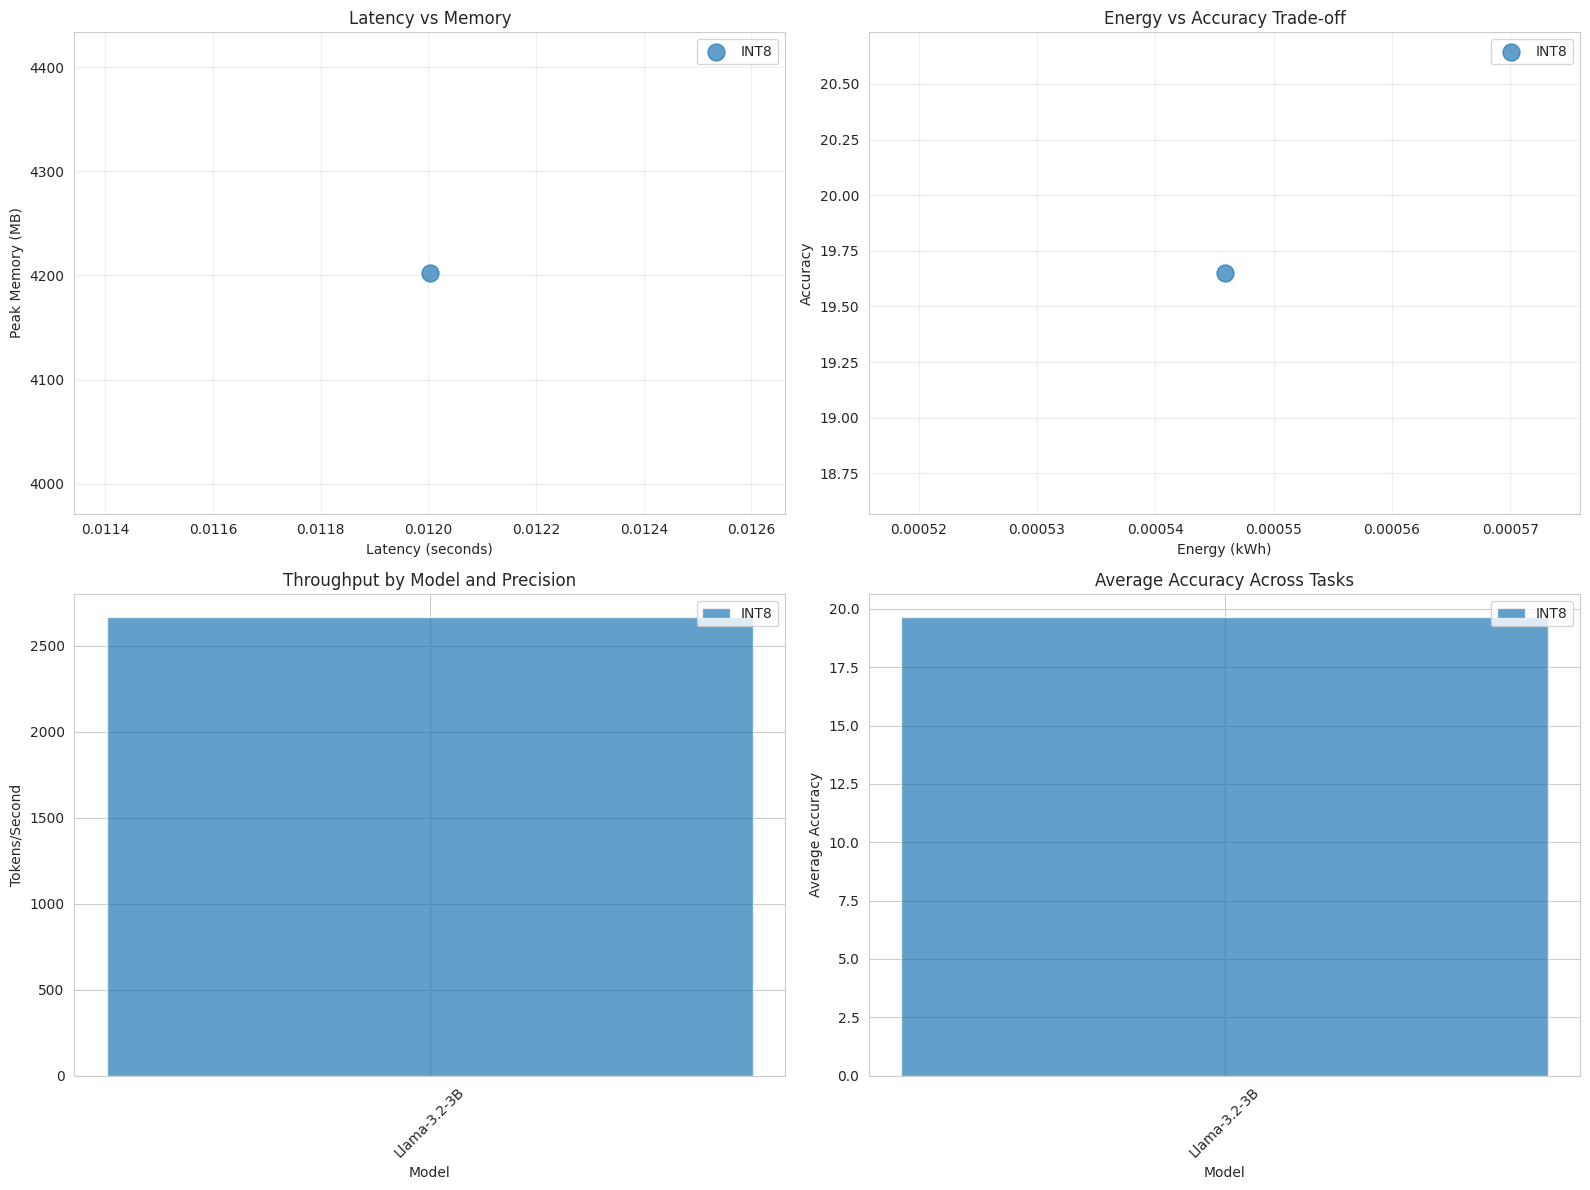

✓ Visualizations saved: slim_eval_results/pareto_frontiers.png


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Latency vs Memory
ax1 = axes[0, 0]
for precision in results_df["precision"].unique():
    data = results_df[results_df["precision"] == precision]
    ax1.scatter(
        data["mean_latency_s"],
        data["mean_peak_mem_mb"],
        label=precision.upper(),
        s=150,
        alpha=0.7,
    )
ax1.set_xlabel("Latency (seconds)")
ax1.set_ylabel("Peak Memory (MB)")
ax1.set_title("Latency vs Memory")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Energy vs Accuracy (if available)
if "energy_kwh" in results_df.columns and any(
    "accuracy" in col for col in results_df.columns
):
    ax2 = axes[0, 1]
    acc_col = [col for col in results_df.columns if "accuracy" in col][0]
    for precision in results_df["precision"].unique():
        data = results_df[results_df["precision"] == precision]
        ax2.scatter(
            data["energy_kwh"], data[acc_col], label=precision.upper(), s=150, alpha=0.7
        )
    ax2.set_xlabel("Energy (kWh)")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Energy vs Accuracy Trade-off")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Plot 3: Throughput comparison
ax3 = axes[1, 0]
models_short = results_df["model"].str.split("/").str[-1]
for precision in results_df["precision"].unique():
    data = results_df[results_df["precision"] == precision]
    indices = data.index
    ax3.bar(
        [models_short[i] for i in indices],
        data["tokens_per_second"],
        label=precision.upper(),
        alpha=0.7,
    )
ax3.set_xlabel("Model")
ax3.set_ylabel("Tokens/Second")
ax3.set_title("Throughput by Model and Precision")
ax3.legend()
ax3.tick_params(axis="x", rotation=45)

# Plot 4: Accuracy comparison across tasks
ax4 = axes[1, 1]
accuracy_cols = [col for col in results_df.columns if "accuracy" in col]
if accuracy_cols:
    # Average accuracy across all tasks
    results_df["avg_accuracy"] = results_df[accuracy_cols].mean(axis=1)
    for precision in results_df["precision"].unique():
        data = results_df[results_df["precision"] == precision]
        indices = data.index
        ax4.bar(
            [models_short[i] for i in indices],
            data["avg_accuracy"],
            label=precision.upper(),
            alpha=0.7,
        )
    ax4.set_xlabel("Model")
    ax4.set_ylabel("Average Accuracy")
    ax4.set_title("Average Accuracy Across Tasks")
    ax4.legend()
    ax4.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "pareto_frontiers.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"✓ Visualizations saved: {OUTPUT_DIR / 'pareto_frontiers.png'}")

## Cell 17: Summary Statistics Tables

In [32]:
# Create comprehensive summary
summary_stats = (
    results_df.groupby(["precision"])
    .agg(
        {
            "mean_latency_s": ["mean", "std", "min", "max"],
            "mean_peak_mem_mb": ["mean", "std", "min", "max"],
            "tokens_per_second": ["mean", "std", "min", "max"],
        }
    )
    .round(4)
)

if "energy_kwh" in results_df.columns:
    energy_stats = (
        results_df.groupby(["precision"])
        .agg(
            {
                "energy_kwh": ["mean", "std"],
                "avg_power_watts": ["mean", "std"],
            }
        )
        .round(4)
    )
    summary_stats = pd.concat([summary_stats, energy_stats], axis=1)

print("\n{'#'*70}")
print("SUMMARY STATISTICS BY PRECISION")
print(f"{'#' * 70}\n")
print(summary_stats)

summary_stats.to_csv(OUTPUT_DIR / "summary_statistics.csv")
print(f"\n✓ Summary saved: {OUTPUT_DIR / 'summary_statistics.csv'}")


{'#'*70}
SUMMARY STATISTICS BY PRECISION
######################################################################

          mean_latency_s                   mean_peak_mem_mb                 \
                    mean std    min    max             mean std        min   
precision                                                                    
int8               0.012 NaN  0.012  0.012        4202.3931 NaN  4202.3931   

                     tokens_per_second                           energy_kwh  \
                 max              mean std        min        max       mean   
precision                                                                     
int8       4202.3931         2666.0755 NaN  2666.0755  2666.0755     0.0005   

              avg_power_watts      
          std            mean std  
precision                          
int8      NaN         75.6789 NaN  

✓ Summary saved: slim_eval_results/summary_statistics.csv


## Cell 18: Paper-Ready Results Table

In [33]:
# Create formatted table for academic papers
paper_columns = [
    "model",
    "precision",
    "mean_latency_s",
    "mean_peak_mem_mb",
    "tokens_per_second",
]

if "energy_kwh" in results_df.columns:
    paper_columns.append("energy_kwh")

accuracy_cols = [col for col in results_df.columns if "accuracy" in col]
if accuracy_cols:
    paper_columns.extend(accuracy_cols[:3])  # Include first 3 accuracy metrics

paper_table = results_df[paper_columns].copy()
paper_table["model"] = paper_table["model"].str.split("/").str[-1]

# Rename columns for readability
rename_map = {
    "mean_latency_s": "Latency (s)",
    "mean_peak_mem_mb": "Memory (MB)",
    "tokens_per_second": "Tokens/s",
    "energy_kwh": "Energy (kWh)",
}
paper_table = paper_table.rename(columns=rename_map)
paper_table = paper_table.round(4)

print("\n{'#'*70}")
print("PAPER-READY RESULTS TABLE")
print(f"{'#' * 70}\n")
print(paper_table.to_string(index=False))

# Save as CSV and LaTeX
paper_table.to_csv(OUTPUT_DIR / "paper_results.csv", index=False)
latex_table = paper_table.to_latex(index=False, float_format="%.4f")
with open(OUTPUT_DIR / "paper_results.tex", "w") as f:
    f.write(latex_table)

print(f"\n✓ Paper table saved: {OUTPUT_DIR / 'paper_results.csv'}")
print(f"✓ LaTeX table saved: {OUTPUT_DIR / 'paper_results.tex'}")


{'#'*70}
PAPER-READY RESULTS TABLE
######################################################################

       model precision  Latency (s)  Memory (MB)  Tokens/s  Energy (kWh)  mmlu_accuracy  gsm8k_accuracy  hellaswag_accuracy
Llama-3.2-3B      int8        0.012    4202.3931 2666.0755        0.0005        19.6506             NaN                 NaN

✓ Paper table saved: slim_eval_results/paper_results.csv
✓ LaTeX table saved: slim_eval_results/paper_results.tex


## Cell 19: Export JSON Results (for sharing/archiving)

In [34]:
# Export all results as JSON for easy sharing
json_output = {
    "metadata": {
        "timestamp": datetime.now().isoformat(),
        "models": MODELS,
        "precisions": PRECISIONS,
        "accuracy_tasks": ACCURACY_TASKS,
        "num_runs": NUM_RUNS,
        "batch_size": BATCH_SIZE,
    },
    "results": results_df.to_dict(orient="records"),
}

if analysis_results:
    json_output["analysis"] = analysis_df.to_dict(orient="records")

json_path = OUTPUT_DIR / "complete_results.json"
with open(json_path, "w") as f:
    json.dump(json_output, f, indent=2)

print(f"✓ JSON results saved: {json_path}")

✓ JSON results saved: slim_eval_results/complete_results.json


## Cell 20: Generate Executive Summary Report

In [35]:
# Create a text report summarizing key findings
report_lines = [
    "=" * 70,
    "SLiM-EVAL: EXECUTIVE SUMMARY REPORT",
    "=" * 70,
    f"\nGenerated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    f"\nModels Evaluated: {len(results_df['model'].unique())}",
    f"Precision Modes: {', '.join(results_df['precision'].unique())}",
    f"Total Configurations: {len(results_df)}",
    "\n" + "=" * 70,
    "\nKEY FINDINGS:",
    "=" * 70,
]

# Find best performers
if len(results_df) > 0:
    # Fastest model
    fastest = results_df.loc[results_df["mean_latency_s"].idxmin()]
    report_lines.append(f"\n1. FASTEST MODEL:")
    report_lines.append(
        f"   {fastest['model'].split('/')[-1]} ({fastest['precision']})"
    )
    report_lines.append(f"   Latency: {fastest['mean_latency_s']:.4f}s")

    # Most memory efficient
    mem_efficient = results_df.loc[results_df["mean_peak_mem_mb"].idxmin()]
    report_lines.append(f"\n2. MOST MEMORY EFFICIENT:")
    report_lines.append(
        f"   {mem_efficient['model'].split('/')[-1]} ({mem_efficient['precision']})"
    )
    report_lines.append(f"   Memory: {mem_efficient['mean_peak_mem_mb']:.2f} MB")

    # Highest throughput
    highest_throughput = results_df.loc[results_df["tokens_per_second"].idxmax()]
    report_lines.append(f"\n3. HIGHEST THROUGHPUT:")
    report_lines.append(
        f"   {highest_throughput['model'].split('/')[-1]} ({highest_throughput['precision']})"
    )
    report_lines.append(
        f"   Throughput: {highest_throughput['tokens_per_second']:.2f} tokens/s"
    )

    # Best accuracy (if available)
    accuracy_cols = [col for col in results_df.columns if "accuracy" in col]
    if accuracy_cols:
        results_df["avg_accuracy"] = results_df[accuracy_cols].mean(axis=1)
        best_accuracy = results_df.loc[results_df["avg_accuracy"].idxmax()]
        report_lines.append(f"\n4. BEST AVERAGE ACCURACY:")
        report_lines.append(
            f"   {best_accuracy['model'].split('/')[-1]} ({best_accuracy['precision']})"
        )
        report_lines.append(f"   Avg Accuracy: {best_accuracy['avg_accuracy']:.4f}")

    # Quantization impact
    if analysis_results:
        report_lines.append(f"\n" + "=" * 70)
        report_lines.append("QUANTIZATION IMPACT:")
        report_lines.append("=" * 70)

        avg_speedup = analysis_df["speedup"].mean()
        avg_mem_reduction = analysis_df["memory_reduction_pct"].mean()

        report_lines.append(f"\nINT8/INT4 Quantization Effects (Average):")
        report_lines.append(f"  • Speedup: {avg_speedup:.2f}x")
        report_lines.append(f"  • Memory Reduction: {avg_mem_reduction:.1f}%")

        if "energy_reduction_pct" in analysis_df.columns:
            avg_energy_reduction = analysis_df["energy_reduction_pct"].mean()
            report_lines.append(f"  • Energy Reduction: {avg_energy_reduction:.1f}%")

        acc_drop_cols = [col for col in analysis_df.columns if "acc_drop" in col]
        if acc_drop_cols:
            avg_acc_drop = analysis_df[acc_drop_cols].mean().mean()
            report_lines.append(f"  • Average Accuracy Drop: {avg_acc_drop:.2f}%")

report_lines.append("\n" + "=" * 70)
report_lines.append("END OF REPORT")
report_lines.append("=" * 70)

report_text = "\n".join(report_lines)
print(report_text)

# Save report
report_path = OUTPUT_DIR / "executive_summary.txt"
with open(report_path, "w") as f:
    f.write(report_text)

print(f"\n✓ Executive summary saved: {report_path}")

SLiM-EVAL: EXECUTIVE SUMMARY REPORT

Generated: 2025-11-29 00:26:57

Models Evaluated: 1
Precision Modes: int8
Total Configurations: 1


KEY FINDINGS:

1. FASTEST MODEL:
   Llama-3.2-3B (int8)
   Latency: 0.0120s

2. MOST MEMORY EFFICIENT:
   Llama-3.2-3B (int8)
   Memory: 4202.39 MB

3. HIGHEST THROUGHPUT:
   Llama-3.2-3B (int8)
   Throughput: 2666.08 tokens/s

4. BEST AVERAGE ACCURACY:
   Llama-3.2-3B (int8)
   Avg Accuracy: 19.6506

END OF REPORT

✓ Executive summary saved: slim_eval_results/executive_summary.txt


## Cell 21: Quick Single Model Test (For Debugging)

In [ ]:
# Uncomment to test a single model quickly
# TEST_MODEL = "meta-llama/Llama-3.2-3B-Instruct"
# TEST_PRECISION = "fp16"
#
# print(f"Quick test: {TEST_MODEL} in {TEST_PRECISION}")
# results = run_complete_benchmark(TEST_MODEL, TEST_PRECISION)
# if results:
#     print("\nTest Results:")
#     for key, value in results.items():
#         print(f"  {key}: {value}")

print("Quick test cell ready (not executed)")

---
## Summary of Complete Framework

### Metrics Tracked:
1. **Latency** - Mean, median, P95, P99 inference time
2. **Memory** - Peak and average GPU memory usage
3. **Energy** - Power consumption and energy per query
4. **Accuracy** - Task performance on MMLU, GSM8K, HellaSwag, etc.

### Workflow:
1. **Setup** - Configure models, precisions, benchmarks
2. **Quantize** (optional) - Pre-quantize models with llm-compressor
3. **Benchmark** - Run latency, memory, energy, and accuracy tests
4. **Analyze** - Calculate trade-offs and efficiency metrics
5. **Visualize** - Generate plots and Pareto frontiers
6. **Report** - Export results in CSV, JSON, LaTeX formats

### Next Steps:
- Add carbon emissions tracking (multiply energy by grid carbon intensity)
- Integrate additional benchmarks (BBH, MATH, MedQA, LegalBench)
- Add throughput benchmarking under different batch sizes
- Implement automated Pareto frontier analysis
- Add statistical significance testing for accuracy differences

In [ ]:
# nohup jupyter nbconvert --to notebook --execute working_file.ipynb \
#     --output working_file_executed.ipynb > working_file.log 2>&1 &